In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gplately
from gplately import pygplates
import pandas as pd
import geopandas as gpd
import cmcrameri as cmc

import matplotlib
matplotlib.rcParams['font.family'] = 'Helvetica'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams.update({
    "pdf.use14corefonts": True
})


reconstruction_times = np.arange(0,101,1)
extent_global = [-180,180,-90,90]

In [2]:
# Call GPlately's DataServer from the download.py module
gdownload = gplately.download.DataServer("Clennett2020")

# Obtain all rotation files, topology features and static polygons from Muller et al. 2019
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Call the PlotTopologies object
time = 0 #Ma
gplot = gplately.plot.PlotTopologies(model, coastlines, continents, COBs, time=time)

Checking whether the requested files need to be updated...
Requested files are up-to-date!
Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [3]:
etopo_raster = gplately.download.get_raster("ETOPO1_grd")

Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [5]:
metal_dict = dict()

commodities = ['Cu (Mt)', 'Pb (Mt)', 'Zn (Mt)', 'Ni (Mt)']
sheets = ['PbZn-CD', 'PbZn-MVT', 'Cu-sed', 'Magmatic Ni', 'VMS', 'Cu-por', 'IOCG']

for sheet in sheets:
    df = pd.read_excel('data/base_metal_deposit_compilation.xls', sheet_name=sheet, na_values='ND')
    df = df[df['Age (Ga)'].notna()]
    df = df[df['Age (Ga)']*1000 <= reconstruction_times.max()]

    if df.shape[0] > 0:
        metal_dict[sheet] = df
    else:
        sheets.remove(sheet)
        
symbols = ['o', 'v', 's', '*', 'd', '^', 'P']*2

df_por = metal_dict['Cu-por']

In [6]:
# fracture zones
fz_raster = gplately.Raster("output_grids/fz_grid_0Ma.nc")

# seamounts
seamounts_filename = "data/Pacific_synthetic_seamounts.gpml"
seamounts = pygplates.FeatureCollection(seamounts_filename)

# LIPs
LIP_conjugates_filename = "data/LIP_conjugates/LIP_conjugates_0Ma.shp"
LIPs_filename = "data/Whittaker_etal_2015_LIPs.gpmlz"
LIPs = pygplates.FeatureCollection(LIP_conjugates_filename)
LIPs.add(pygplates.FeatureCollection(LIPs_filename))

# hotspots
hotspots_filename = "data/Hotspots_Compilation_Whittaker_etal.gpmlz"
hotspots = pygplates.FeatureCollection(hotspots_filename)

# reconstruct to 0 Ma
seamounts_0Ma = model.reconstruct(seamounts, 0)
LIPs_0Ma = model.reconstruct(LIPs, 0)

# obtain as dataframe
df_seamounts = gplot.get_feature(seamounts_0Ma)
df_LIPs = gplot.get_feature(LIPs_0Ma)
df_hotspots = gplot.get_feature(hotspots)

In [7]:
vmin = np.nanpercentile(etopo_raster.data, 1)

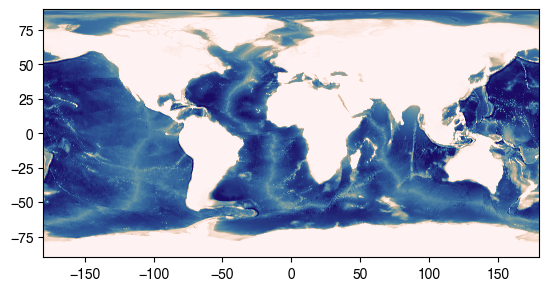

In [8]:
etopo_raster.imshow(cmap=cmc.cm.lapaz, vmin=vmin, vmax=0,)

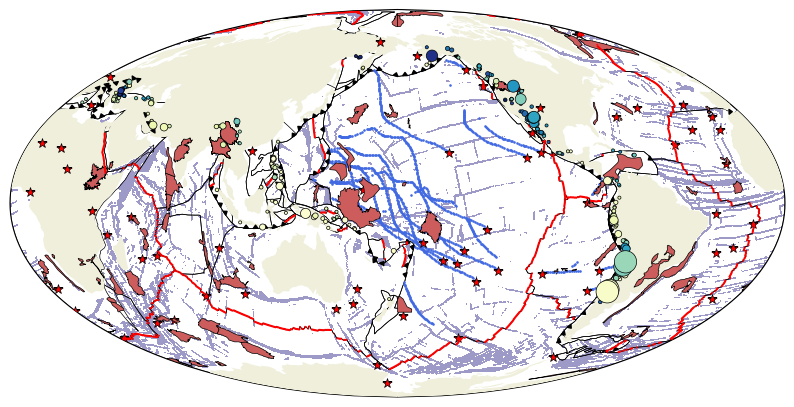

In [9]:
fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude=180))
ax1.set_global()
# ax1.add_feature(cfeature.SEA, edgecolor='k', linewidth=0.5, zorder=5)
# ax1.coastlines(facecolor='0.8')

# vmin = np.nanpercentile(etopo_raster.data, 5)
# im = etopo_raster.imshow(ax1, cmap=cmc.cm.lapaz, vmin=vmin, vmax=0, alpha=0.2, rasterized=True)

ax1.contourf(fz_raster.data, extent=extent_global, origin='lower', cmap='Purples', levels=(1,1e99),
             transform=ccrs.PlateCarree())

df_seamounts.plot(ax=ax1, marker='.', markersize=3, color='RoyalBlue', transform=ccrs.PlateCarree(), zorder=6)
df_hotspots.plot(ax=ax1, marker='*', markersize=50, facecolor='r', edgecolor='k', linewidth=0.5,
                 transform=ccrs.PlateCarree(), zorder=6)
df_LIPs.plot(ax=ax1, edgecolor='k', linewidth=0.5, facecolor='IndianRed', transform=ccrs.PlateCarree(), zorder=6)

# ax1.add_geometries(shp_seamounts, crs=ccrs.PlateCarree(), facecolor='k', size=10, zorder=10)
ax1.add_feature(cfeature.LAND,  zorder=5)
# gplot.plot_continent_ocean_boundaries(ax1, color='0.9', zorder=4)
gplot.plot_all_topologies(ax1, zorder=4, linewidth=0.5)
gplot.plot_subduction_teeth(ax1, zorder=6)
gplot.plot_ridges(ax1, color='r', zorder=6)


# create label for each sheet and add commodities
size = df_por['Cu (Mt)'].fillna(0).to_numpy()
order = size.argsort()
sc = ax1.scatter(df_por['Lon'].iloc[order], 
                 df_por['Lat'].iloc[order], 
                 s=5+size[order]*2, 
                 c=df_por['Age (Ga)'].iloc[order]*1000, 
                 marker='o', cmap='YlGnBu',
                 vmin=0, vmax=reconstruction_times.max(),
                 transform=ccrs.PlateCarree(), edgecolor='k', linewidth=0.5, zorder=7)

fig.savefig("figures/seafloor_anomalies_0Ma.pdf", dpi=300, bbox_inches='tight')

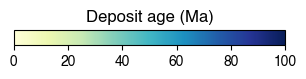

In [10]:
fig = plt.figure(figsize=(3.5,0.2))
cax = fig.add_subplot(111, title='Deposit age (Ma)')
fig.colorbar(sc, cax=cax, orientation='horizontal', ticks=np.arange(0,200,20))
fig.savefig("figures/seafloor_anomalies_0Ma_cbar.pdf", dpi=300, bbox_inches='tight')

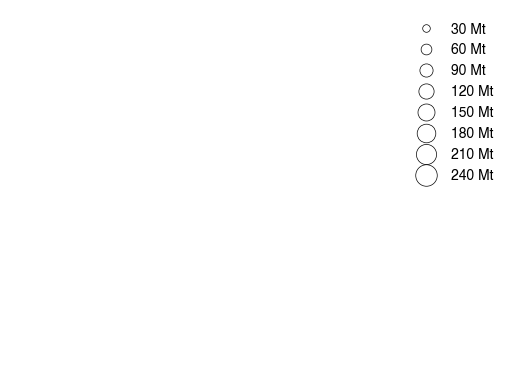

In [11]:
fig = plt.figure()
ax= fig.add_subplot(111)
ax.axis('off')
handles, labels = sc.legend_elements(prop='sizes', num=np.arange(30,260,30), fmt='{x:.0f} Mt')
for handle in handles:
    handle.set_markeredgecolor('k')
    handle.set_markerfacecolor('none')
    handle.set_markeredgewidth(0.5)
ax.legend(handles, labels, frameon=False, )
fig.savefig("figures/seafloor_anomalies_0Ma_legend.pdf", dpi=300, bbox_inches='tight')